W-D films (thickness of 0.5 mm) were co-deposited on Cu substrates (thickness of 3 mm) by pulse laser deposition technique in the D atmosphere ($P_{D_2}=30$ Pa). The D content in W-D films was analysed by means of TDS with the heating rate of 0.5 K/s and the maximal temperature up to 1000 K. 

To simulate the release of D during TDS, we make a strong assumption that a negligible fraction of D migrates into the Cu substrate. Therefore, only D transport in the W film is modelled. The D diffusivity in the W film is defined by scaling the corresponding value for H ([N. Fernandez et al.](https://www.sciencedirect.com/science/article/pii/S1359645415003043)) by a factor of $1/\sqrt{2}$. We found that 4 types of traps, homogeneously distributed within the film, is enough to reproduce the TDS spectrum. The fitting procedure was done according to the methodology of [R. Delaporte-Mathurin et al.](https://www.sciencedirect.com/science/article/pii/S2352179121000661).

# Fitting the experimental spectrum

In [1]:
import festim as F
import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

mpl_params = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [
            r"\usepackage{siunitx}",
            r"\sisetup{detect-all}",
            r"\usepackage{amsmath}",
            r"\usepackage[utf8]{inputenc}",
            r"\usepackage[russian]{babel}",
        ]
    ),
    "axes.spines.right": False,
    "axes.spines.top": False,
    "font.family": "Times New Roman",
    "font.size": 12,
    "legend.frameon": False,
}

plt.rcParams.update(mpl_params)
mm2inch = 1e-1 / 2.54

/home/vvkulagin/anaconda3/envs/PhD-env/lib/python3.11/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


We define a function that will run a FESTIM model for different trap properties.

In [2]:
def TDS(n1, E_p1, n2, E_p2, n3, E_p3, n4, E_p4):
    """Runs the simulation with parameters p that represent:

    Args:
        n1 (float): concentration of trap 1, at. fr.
        E_p1 (float): detrapping barrier from trap 1, eV
        n2 (float): concentration of trap 2, at. fr.
        E_p2 (float): detrapping barrier from trap 2, eV
        n3 (float): concentration of trap 3, at. fr.
        E_p3 (float): detrapping barrier from trap 3, eV
        n4 (float): concentration of trap 4, at. fr.
        E_p4 (float): detrapping barrier from trap 4, eV

    Returns:
        F.DerivedQuantities: the derived quantities of the simulation
    """
    w_atom_density = 6.31e28  # atom/m3
    D0_W = 1.93e-7 / np.sqrt(2)
    Ed_W = 0.2

    # Define Simulation object
    model = F.Simulation()

    # Define a simple mesh
    vertices = np.linspace(0, 0.5e-6, num=500)

    model.mesh = F.MeshFromVertices(vertices)

    # Define material properties
    tungsten = F.Material(
        id=1,
        D_0=D0_W,
        E_D=Ed_W,
    )

    model.materials = [tungsten]

    # Define traps
    trap_1 = F.Trap(
        k_0=D0_W / (1.1e-10**2 * 6 * w_atom_density),
        E_k=Ed_W,
        p_0=1e13,
        E_p=E_p1,
        density=n1 * w_atom_density,
        materials=tungsten,
    )

    trap_2 = F.Trap(
        k_0=D0_W / (1.1e-10**2 * 6 * w_atom_density),
        E_k=Ed_W,
        p_0=1e13,
        E_p=E_p2,
        density=n2 * w_atom_density,
        materials=tungsten,
    )

    trap_3 = F.Trap(
        k_0=D0_W / (1.1e-10**2 * 6 * w_atom_density),
        E_k=Ed_W,
        p_0=1e13,
        E_p=E_p3,
        density=n3 * w_atom_density,
        materials=tungsten,
    )

    trap_4 = F.Trap(
        k_0=D0_W / (1.1e-10**2 * 6 * w_atom_density),
        E_k=Ed_W,
        p_0=1e13,
        E_p=E_p4,
        density=n4 * w_atom_density,
        materials=tungsten,
    )

    model.traps = [trap_1, trap_2, trap_3, trap_4]

    # Set initial conditions
    model.initial_conditions = [
        F.InitialCondition(field="1", value=n1 * w_atom_density),
        F.InitialCondition(field="2", value=n2 * w_atom_density),
        F.InitialCondition(field="3", value=n3 * w_atom_density),
        F.InitialCondition(field="4", value=n4 * w_atom_density),
    ]

    # Set boundary conditions
    model.boundary_conditions = [F.DirichletBC(surfaces=1, value=0, field=0)]

    # Define the material temperature evolution
    ramp = 0.5  # K/s

    model.T = F.Temperature(value=300 + ramp * F.t)

    # Define the simulation settings
    model.dt = F.Stepsize(
        initial_value=0.1,
        stepsize_change_ratio=1.1,
        max_stepsize=1,
        dt_min=1e-6,
    )

    model.settings = F.Settings(
        absolute_tolerance=1e10,
        relative_tolerance=1e-10,
        final_time=1400,
        maximum_iterations=50,
    )

    # Define the exports
    derived_quantities = F.DerivedQuantities(
        [
            F.HydrogenFlux(surface=1),
            F.AverageVolume(field="T", volume=1),
            F.TotalVolume(field="1", volume=1),
            F.TotalVolume(field="2", volume=1),
            F.TotalVolume(field="3", volume=1),
            F.TotalVolume(field="4", volume=1),
        ],
        show_units=True,
    )

    model.exports = [derived_quantities]
    model.initialise()
    model.run()

    return derived_quantities

Then, we define an error function that will be minimised. We will use average absolute error as a metric.

In [3]:
def info(i, p):
    """
    Print information during the fitting procedure
    """
    print("-" * 40)
    print(f"i = {i}")
    print("New simulation.")
    print(f"Point is: {p}")


def error_function(prm):
    """
    Compute average absolute error between simulation and reference
    """
    global i

    i += 1
    info(i, prm)

    # Filter the results if a negative value is found
    if any([e < 0 for e in prm]):
        return 1e30

    try:
        # Get the simulation result
        res = TDS(*prm)

        T = np.array(res.filter(fields="T").data)
        flux = -np.array(res.filter(fields="solute", surfaces=1).data)

        interp_tds = interp1d(T, flux, fill_value="extrapolate")

        # Compute the mean absolute error between sim and ref
        err = np.abs(interp_tds(ref[:, 0]) - ref[:, 1]).mean()

        print(f"Average absolute error is : {err:.2e}")
        return err

    except:
        print(f"ERROR")
        return 1e30

**NOTE:** Uncomment the code block below to run the minimisation procedure

In [4]:
ref = np.genfromtxt(
    "./experimental_data/TDS_S160724.csv", delimiter=",", skip_header=1
)  # get the experimental data

"""
i = 0  # initialise counter

# Set the tolerances
fatol = 1e17
xatol = 1e-4

initial_guess = [
    0.01,
    1.0,
    0.02,
    1.1,
    0.02,
    1.3,
    0.01,
    1.5,
]

# Minimise the error function
pred = minimize(
    error_function,
    np.array(initial_guess),
    method="Nelder-Mead",
    options={"disp": True, "fatol": fatol, "xatol": xatol},
)

optimised_parameters = pred.x
"""

optimised_parameters = [
    0.02894656,
    1.1081157,
    0.01790,
    1.27906163,
    0.01967725,
    1.53602897,
    0.00600191,
    1.81760592,
]

We now run the FESTIM model to obtain the final result.

In [5]:
results = TDS(*optimised_parameters)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-t

# Plot the results

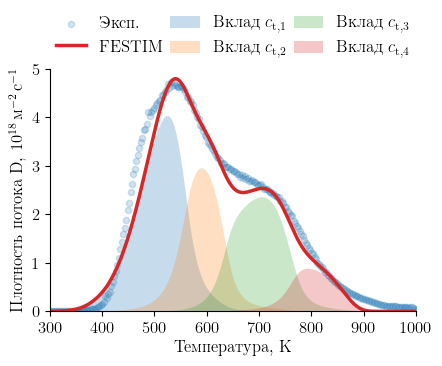

In [6]:
T = results.filter(fields="T").data
flux = -np.array(results.filter(fields="solute", surfaces=1).data)

tr1 = np.array(results.filter(fields="1").data)
tr2 = np.array(results.filter(fields="2").data)
tr3 = np.array(results.filter(fields="3").data)
tr4 = np.array(results.filter(fields="4").data)
time = np.array(results.t)

dtr1 = -np.diff(tr1) / np.diff(time) / 1e18
dtr2 = -np.diff(tr2) / np.diff(time) / 1e18
dtr3 = -np.diff(tr3) / np.diff(time) / 1e18
dtr4 = -np.diff(tr4) / np.diff(time) / 1e18

plt.figure(figsize=(120 * mm2inch, 80 * mm2inch))

plt.scatter(
    ref[::5, 0],
    ref[::5, 1] / 1e18,
    marker="o",
    s=20,
    alpha=0.2,
    zorder=-2,
    label="Эксп.",
    color="tab:blue",
)
plt.plot(
    T,
    flux / 1e18,
    label="FESTIM",
    color="tab:red",
    lw=2.5,
)


plt.fill_between(
    T[1:], np.zeros_like(dtr1), dtr1, alpha=0.25, label=r"Вклад $c_\mathrm{t,1}$"
)

plt.fill_between(
    T[1:], np.zeros_like(dtr1), dtr2, alpha=0.25, label=r"Вклад $c_\mathrm{t,2}$"
)

plt.fill_between(
    T[1:], np.zeros_like(dtr1), dtr3, alpha=0.25, label=r"Вклад $c_\mathrm{t,3}$"
)

plt.fill_between(
    T[1:], np.zeros_like(dtr1), dtr4, alpha=0.25, label=r"Вклад $c_\mathrm{t,4}$"
)


plt.ylabel(r"Плотность потока D, $10^{18}\,$м$^{-2}\,$c$^{-1}$")
plt.xlabel(r"Температура, К")

plt.xlim(300, 1000)
plt.xticks([i for i in range(300, 1100, 100)])
plt.ylim(0, 5)
plt.legend(
    bbox_to_anchor=(0, 1.02, 1, 0.2),
    loc="lower left",
    mode="expand",
    borderaxespad=0,
    ncol=3,
    handlelength=1.75,
)

plt.savefig(
    "../../../Thesis/images/LID_TDS.pdf",
    bbox_inches="tight",
    pad_inches=0.01,
)
plt.show()